In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

### 문제 1
호주 멜버른의 주택 가격 데이터셋 melb_data.csv으로 주택 가격을 예측하고,   
각종 평가지표를 사용하여 결정트리 모델을 평가하세요.

#### Data Description 

* `Rooms`: 방 개수

* `Price`: 가격(단위: $ 달러)

* `Type`: 주택 유형   
br - bedroom(s); h - house,cottage,villa, semi,terrace; u - unit, duplex; t - townhouse; dev site - development site; o res - other residential.

* `Distance`: Distance from CBD(Central Business District : 도심 지역)

* `Bedroom2` : Scraped # of Bedrooms (from different source) (주요 침실 개수)

* `Bathroom`: Number of Bathrooms

* `Car`: Number of carspots

* `Landsize`: Land Size

* `BuildingArea`: Building Size

* `CouncilArea`: Governing council for the area


우선 다음 코드들을 실행하여 melb_data변수명으로 데이터를 로드하고   
결정트리 분석에 필요한 컬럼만 남기고 결손값을 처리합니다.      
<span style='color:green'>(로컬 환경에 알맞게 file_path를 변경하세요)</span>
      
* feature 데이터 = [Rooms, Type, Distance, Bedroom2, Bathroom, Car, Landsize, BuildingArea, CouncilArea]   
* label 데이터 = Price      
   
(Price 값이 양적 자료이기 때문에 분류보단 회귀방식의 모델이 더 적합하지만, 결정트리를 사용하기 위해 편의상 Price값을 사분위수에 따라 범주형 자료로 변환하여 사용합니다.)

In [2]:
#(문제 아님)
file_path = 'melb_data.csv'
drop_columns=['Date','YearBuilt','Suburb','SellerG','Postcode','Address','Method','Lattitude','Longtitude','Propertycount']
melb_data = pd.read_csv(file_path).drop(columns=drop_columns,axis=1)
melb_data['CouncilArea'] = melb_data['CouncilArea'].fillna('Moreland')
melb_data['BuildingArea'] = melb_data['BuildingArea'].fillna(melb_data['BuildingArea'].mean())
melb_data['Car'] = melb_data['Car'].fillna(melb_data['Car'].median())

In [3]:
melb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rooms         13580 non-null  int64  
 1   Type          13580 non-null  object 
 2   Price         13580 non-null  float64
 3   Distance      13580 non-null  float64
 4   Bedroom2      13580 non-null  float64
 5   Bathroom      13580 non-null  float64
 6   Car           13580 non-null  float64
 7   Landsize      13580 non-null  float64
 8   BuildingArea  13580 non-null  float64
 9   CouncilArea   13580 non-null  object 
 10  Regionname    13580 non-null  object 
dtypes: float64(7), int64(1), object(3)
memory usage: 1.1+ MB


LabelEncoder를 사용하여 인코딩을 합니다.

In [4]:
#(문제 아님)
categorical_features = [ 'Type', 'CouncilArea','Regionname']
for col in categorical_features:
    le = LabelEncoder()
    melb_data[col] = le.fit_transform(melb_data[col])

### 1-1 (5점) - 전처리
label 데이터(target)로 Price 를 사용할 것입니다.   
그러나 양적 자료인 Price를 결정트리에 알맞게 범주형 자료로 변형하기 위해서 사분위수(quartile)와 2차세션 복습과제 때 학습했던 Tukey Fences 개념을 활용할 것입니다.   
아래 규칙과 같이 Price값을 바꾸세요.
   
   <span style='color:red'>[ 규칙 ]</span>
* 0 이상, Q1 미만 : '0' 
* Q1 이상, Q2 미만 : '1' 
* Q2 이상, Q3 미만 : '2' 
* Q3 이상 : '3' 
      
다음은 커스텀 함수 price_to_level()입니다. 위의 규칙에 맞게 빈칸을 알맞게 채우세요.   
   (문제에 적힌 대로 함수를 작성하지 않아도 됩니다. 아래 함수 출력 결과(0 1 2 3)가 일치하기만 하면 됩니다.)

In [5]:
def price_to_level(prices): 
    
    # 문제) 사분위수(Q1,Q2,Q3) 구하기
    Q1 = melb_data['Price'].quantile(0.25)
    Q2 = melb_data['Price'].quantile(0.50)
    Q3 = melb_data['Price'].quantile(0.75)

    # 문제) 위의 규칙에 맞게 Price값에 따라 레벨로 변환하도록 코드를 작성하세요
    
    if (prices >= Q3) :
        return '3'
    elif (prices >= Q2) & (prices < Q3) :
        return '2'
    elif (prices >= Q1) & (prices < Q2) :
        return '1'
    else:
        return '0'
   
      
# price_to_level() 커스텀 함수를 사용하여 Price컬럼값을 변경합니다.
melb_data['Price'] = melb_data['Price'].apply(lambda x: price_to_level(x))

# 문제) Price 컬럼명을 PriceLevel로 변경하세요. (힌트: pandas의 rename() 사용)
melb_data.rename(columns={"Price": "PriceLevel"}, inplace=True)

아래 코드를 실행하여 데이터 변환이 제대로 이루어졌는지 확인하세요.

In [6]:
#(문제아님)
### 간단하게 price_to_level() 커스텀 함수를 확인하세요 ###
print(melb_data.loc[8,'PriceLevel'],melb_data.loc[3,'PriceLevel'],
      melb_data.loc[1,'PriceLevel'],melb_data.loc[0,'PriceLevel'])
### 출력 결과가 0 1 2 3 이면, 커스텀 함수를 올바르게 작성한 것입니다. ###

0 1 2 3


### 1-2 (5점) - 정확도
melb_data 를 train_test_split() 함수로 학습/테스트용 데이터로 분리하고, 간단하게 DecisionTreeClassifier 를 사용하여 모델을 학습하고 PriceLevel을 예측해보세요. 그리고 예측 결과의 정확도(accuracy)를 평가해서 소수점 5번째 자리에서 반올림하여 출력해보세요.   
<span style='color:green'>(DecisionTreeClassfier 생성자 함수와 train_test_split의 random_state 파라미터값은 모두 10을 전달해주세요, test_size는 0.25로 설정해주세요.)</span>
* features 데이터 : PriceLevel을 제외한 나머지 컬럼   
* label 데이터 : PriceLevel 컬럼

In [7]:
melb_data.head(3)

,Rooms,Type,PriceLevel,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,CouncilArea,Regionname
0,2,0,3,2.5,2.0,1.0,1.0,202.0,151.96765,31,2
1,2,0,2,2.5,2.0,1.0,0.0,156.0,79.00000,31,2
2,3,0,3,2.5,3.0,2.0,0.0,134.0,150.00000,31,2


In [8]:
# features 변수명에 해당 데이터를, label 변수명에 해당 데이터를 저장하고,
features = melb_data.drop(columns=['PriceLevel'], axis=1)
label = melb_data['PriceLevel']

# train_test_split()으로 데이터를 분리하세요.
Xtrain, Xtest, ytrain, ytest = train_test_split(features, label, test_size=0.25, random_state=10)

# 결정트리 객체를 생성하고 학습, 예측을 수행하세요. (예측값은 'pred' 변수명으로 저장하세요.)
dt_clf = DecisionTreeClassifier(random_state=10)
dt_clf.fit(Xtrain, ytrain)
pred = dt_clf.predict(Xtest)

# 예측 결과를 정확도로 평가하고 평가 결과를 위의 조건대로 반올림하여 출력하세요
round(accuracy_score(ytest, pred), 4)

0.6236

### 1-3 (40점) - 정밀도와 재현율
위의 예측값(pred)과 실제값(y_test)을 토대로 confusion matrix를 구현해보세요.   (다중 분류일 때의 confusion matrix를 학습해봅시다)   
다음과 같은 모양으로 DataFrame객체를 생성해서 출력해보세요.   
   (개수는 해당 경우의 수를 의미)
|          | 0 | 1 | 2 | 3 |
|----------|----------|----------|----------|----------|
| 0 | 개수 | 개수 |개수  |개수  |
| 1 | 개수 | 개수 | 개수 | 개수 |
| 2 | 개수 | 개수 | 개수 | 개수 |
| 3 | 개수 | 개수 | 개수 | 개수 |

**a)**
sklearn.metrics의 confusion_matrix() 함수로 생성한 오차행렬을 cm 변수에 저장하고,
이를 DataFrame객체로 변환해 위의 예시처럼 예쁘게 출력하세요.   
**(5점)**

In [9]:
classes = ['0', '1', '2', '3'] # 레이블 클래스
# 변수 cm에 confusion_matrix를 저장하세요
cm = confusion_matrix(ytest, pred)
cm
# pandas DataFrame으로 변환하여 예쁘게 출력하세요
pd.DataFrame(cm, columns=classes)

,0,1,2,3
0,649,183,22,4
1,175,434,186,45
2,32,186,450,196
3,8,31,210,584


####  직접 재현율(recall)과 정밀도(precision)를 구해서 확인해보세요
힌트: 다중분류의 confusion matrix를 학습하고 macro-averaging과 micro-averaging을 학습하세요.

**b)** macro-averaging(macro-mean) 방식을 사용하여 macro_precision과 macro_recall 값을 구하고 출력하세요.   
(반복문을 사용하여 해결하세요, 변수명도 각각 macro_precision과 macro_recall을 사용하세요.)      
**(13점)**

In [10]:
class_precision = []
class_recall = []

for i in range(4):

    TP = cm[i,i]
    FP = sum(cm[:,i]) - TP
    FN = sum(cm[i,:]) - TP

    class_precision.append(TP/(TP+FP))
    class_recall.append(TP/(TP+FN))

macro_precision =  sum(class_precision)/4
macro_recall = sum(class_recall)/4

print('macro precision : ',macro_precision)
print('macro recall : ',macro_recall )

macro precision :  0.623609372215409
macro recall :  0.6237476721457814


**c)** micro-averaging 방식을 사용하여 micro_precision과 micro_recall 값을 구하고 출력하세요.   
(변수명도 각각 micro_precision과 micro_recall을 사용하세요.)   
(힌트: 위의 반복문에서 미리 TP,FP,FN들을 저장하면 여기선 계산만 하면 됩니다.)   
**(13점)**

In [11]:
class_TP = 0
class_FP = 0
class_FN = 0

for i in range(4):

    TP = cm[i,i]
    FP = sum(cm[:,i]) - TP
    FN = sum(cm[i,:]) - TP

    class_TP += TP
    class_FP += FP
    class_FN += FN

micro_precision = class_TP/(class_TP+class_FP)
micro_recall = class_TP/(class_TP+class_FN)

print('micro precision : ',micro_precision)
print('micro recall : ',micro_recall )

micro precision :  0.6235640648011782
micro recall :  0.6235640648011782


**d)** sklearn.metrics의 classification_report() 함수를 사용하여 구한 평가지표 결과를 clf_report 변수에 저장하세요  
그리고 해당 변수를 DataFrame 객체로 변환하여 출력하세요.   
(힌트 : classification_report()함수의 파라미터들을 학습하고 데이터프레임 객체로 쉽게 변환하는 방법을 찾아보세요)   
**(4점)**

In [12]:
# classification_report를 변수에 저장하고 DataFrame으로 변환하여 출력하세요.
from sklearn.metrics import classification_report
clf_report = classification_report(ytest,pred, target_names=classes, output_dict=True)
print(clf_report)

{'0': {'precision': 0.7511574074074074, 'recall': 0.7564102564102564, 'f1-score': 0.7537746806039489, 'support': 858}, '1': {'precision': 0.5203836930455635, 'recall': 0.5166666666666667, 'f1-score': 0.5185185185185185, 'support': 840}, '2': {'precision': 0.5184331797235023, 'recall': 0.5208333333333334, 'f1-score': 0.5196304849884527, 'support': 864}, '3': {'precision': 0.7044632086851629, 'recall': 0.7010804321728692, 'f1-score': 0.7027677496991577, 'support': 833}, 'accuracy': 0.6235640648011782, 'macro avg': {'precision': 0.623609372215409, 'recall': 0.6237476721457814, 'f1-score': 0.6236728584525194, 'support': 3395}, 'weighted avg': {'precision': 0.6233753984770768, 'recall': 0.6235640648011782, 'f1-score': 0.6234640665811975, 'support': 3395}}


In [13]:
clf_report = pd.DataFrame(clf_report)
clf_report

,0,1,2,3,accuracy,macro avg,weighted avg
precision,0.751157,0.520384,0.518433,0.704463,0.623564,0.623609,0.623375
recall,0.756410,0.516667,0.520833,0.701080,0.623564,0.623748,0.623564
f1-score,0.753775,0.518519,0.519630,0.702768,0.623564,0.623673,0.623464
support,858.000000,840.000000,864.000000,833.000000,0.623564,3395.000000,3395.000000


**e)** 위에서 직접 구한 macro_precision, macro_recall, micro_precision, micro_recall값이 clf_report의 내용과 같은지 소수점 4번째 자리까지 비교하여 출력하세요.
* 출력용 코드 예시   
<code>print('[Macro_P] my_score:{:.4f}, report_score:{:.4f}'.format(macro_precision,report_mac_precision))</code>   
<code>print('[Macro_R] my_score:{:.4f}, report_score:{:.4f}'.format(macro_recall,report_mac_recall))</code>   
<code>print('[Micro_P] my_score:{:.4f}, report_score:{:.4f}'.format(micro_precision,report_mic_precision))</code>   
<code>print('[Micro_R] my_score:{:.4f}, report_score:{:.4f}'.format(micro_recall,report_mic_recall))</code>
      
(힌트: classification_report를 출력해보면 micro averaging한 데이터가 없다! 그러나 micro averaging의 수식을 잘 살펴보면 어떤 평가지표와 의미가 같다는 사실을 알 수 있다.)   
**(5점)**

In [14]:
# 위의 출력 코드 예시를 활용해서 각 평가 결과값들을 비교하여 출력하세요

print('[Macro_P] my_score:{:.4f}, report_score:{:.4f}'.format(macro_precision,clf_report.loc['precision', 'macro avg']))
print('[Macro_R] my_score:{:.4f}, report_score:{:.4f}'.format(macro_recall,clf_report.loc['recall', 'macro avg']))   
print('[Micro_P] my_score:{:.4f}, report_score:{:.4f}'.format(micro_precision,clf_report.loc['precision', 'weighted avg']))  
print('[Micro_R] my_score:{:.4f}, report_score:{:.4f}'.format(micro_recall,clf_report.loc['recall', 'weighted avg']))

[Macro_P] my_score:0.6236, report_score:0.6236
[Macro_R] my_score:0.6237, report_score:0.6237
[Micro_P] my_score:0.6236, report_score:0.6234
[Micro_R] my_score:0.6236, report_score:0.6236


### 문제2 (50점)
위스콘신 유방암 데이터 세트는 종양의 크기, 모양 등의 다양한 속성 값을 기반으로 해당 종양이 악성인지 양성인지를 분류한 데이터 세트입니다. 종양의 양성 여부는 class 컬럼에서 확인할 수 있으며, 양성은 2, 악성은 4로 표시되어 있습니다.  

아래의 코드를 실행해주세요.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import roc_auc_score

2-1. *breast_cancer* 데이터셋을 데이터프레임으로 불러온 후 df 변수에 저장해주세요. 상위 5개의 행을 확인할 수 있도록 출력해주세요.  **(3점)**  
(데이터셋의 첫 번째, 두 번째 열을 삭제한 후, 아래의 사진과 같은 결과가 나오도록 출력해주세요.)
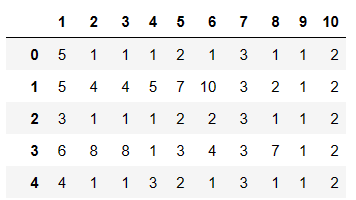

In [16]:
df = pd.read_csv('breast_cancer.csv')
df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,9,10
0,0,1000025,5,1,1,1,2,1,3,1,1,2
1,1,1002945,5,4,4,5,7,10,3,2,1,2
2,2,1015425,3,1,1,1,2,2,3,1,1,2
3,3,1016277,6,8,8,1,3,4,3,7,1,2
4,4,1017023,4,1,1,3,2,1,3,1,1,2


In [17]:
# df 데이터셋의 첫 번째, 두 번째 열을 삭제해주세요.
df.drop(df.columns[[0,1]], axis=1, inplace=True)
df.head()

,1,2,3,4,5,6,7,8,9,10
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


2-2. 아래의 colums_name 변수를 활용하여 0~10까지의 숫자로 되어 있는 컬럼명을 변경해주세요. **(3점)**  
(각각의 컬럼과 columns_name 변수 안의 컬럼명의 순서는 동일합니다. 아래의 사진과 같은 데이터셋의 형태를 띌 수 있도록 컬럼명을 변경해주세요. 아래의 columns_name 변수를 복사해서 코드를 작성해주세요.)

columns_name = ['clump', 'cell_size', 'cell_shape', 'adhesion', 'epithlial', 'bare_nuclei', 
                'chromatin', 'normal_nucleoli', 'mitoses', 'class']
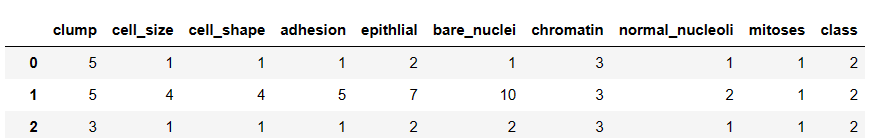

In [18]:
df.columns = ['clump', 'cell_size', 'cell_shape', 'adhesion', 'epithlial', 'bare_nuclei', 
                'chromatin', 'normal_nucleoli', 'mitoses', 'class']

2-3. 다음의 설명에 따라 전처리를 진행해주세요. **(6점)**

In [19]:
# info를 활용하여 데이터타입을 확인해주세요.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   clump            699 non-null    int64 
 1   cell_size        699 non-null    int64 
 2   cell_shape       699 non-null    int64 
 3   adhesion         699 non-null    int64 
 4   epithlial        699 non-null    int64 
 5   bare_nuclei      699 non-null    object
 6   chromatin        699 non-null    int64 
 7   normal_nucleoli  699 non-null    int64 
 8   mitoses          699 non-null    int64 
 9   class            699 non-null    int64 
dtypes: int64(9), object(1)
memory usage: 54.7+ KB


In [20]:
# df 데이터 중 bare_nuclei 컬럼의 값 분포를 확인해주세요. (value_counts 활용)
df['bare_nuclei'].value_counts()

1     402
10    132
2      30
5      30
3      28
8      21
4      19
?      16
9       9
7       8
6       4
Name: bare_nuclei, dtype: int64

In [21]:
# 'bare_nuclei'컬럼에 있는 값 중'?'를 'bare_nuclei' 컬럼의 최빈값으로 바꿔주세요.
df['bare_nuclei'].replace('?', df['bare_nuclei'].mode().iloc[0], inplace=True)

In [22]:
# 'bare_nuclei'컬럼의 데이터 타입을 숫자형(int)으로 바꿔주세요.
df['bare_nuclei']=df['bare_nuclei'].astype('int')

In [23]:
# 양성은 2, 악성은 4로 표시되어 있는 df['class'] 값 중 2(양성)는 숫자 0으로, 4(음성)는 숫자 1로 바꿔주세요.
df['class'].replace(2, 0, inplace=True)
df['class'].replace(4, 1, inplace=True)

2-4. 아래의 설명에 따라 데이터를 분리해주세요. **(3점)**

In [24]:
# 피처 데이터 세트 x, 레이블 데이터 세트 y를 추출해주세요. (레이블 데이터는 class컬럼에 담겨있습니다.)
x = df.drop(columns=['class'])
y = df['class']

2-5. StandardScaler를 활용하여 개별 피처의 평균이 0이고, 분산이 1인 값으로 변환해주세요. 또한, 변환된 데이터 세트를 DataFrame으로 변환해 data_df라는 변수에 저장해주세요. data_df 데이터프레임의 컬럼명은 아래의 columns_name2 변수를 그대로 활용하여 설정해주세요. **(8점)**  
columns_name2 = ['clump', 'cell_size', 'cell_shape', 'adhesion', 'epithlial', 'bare_nuclei', 
                'chromatin', 'normal_nucleoli', 'mitoses']

(columns_name2 변수에 담겨있는 컬럼명의 순서와 데이터프레임 각 열의 순서는 동일하기 때문에 columns_name2 변수를 수정할 필요는 없습니다.)

In [25]:
# StandardScaler 객체 생성
scaler = StandardScaler()

# StandardScaler로 데이터 세트 변환. fit()과 transform() 호출
# columns_name2 변수를 생성해주세요.
# data_df 변수에 변환된 데이터프레임을 저장해주세요.

columns_name2 = ['clump', 'cell_size', 'cell_shape', 'adhesion', 'epithlial', 'bare_nuclei', 
                'chromatin', 'normal_nucleoli', 'mitoses']
data_df = x.copy()
data_df[columns_name2] = scaler.fit_transform(x[columns_name2])


In [26]:
# data_df 데이터프레임의 하위 5개 행을 출력해주세요.
data_df.tail(5)

,clump,cell_size,cell_shape,adhesion,epithlial,bare_nuclei,chromatin,normal_nucleoli,mitoses
694,-0.503866,-0.699995,-0.743299,-0.633247,-0.097628,-0.410685,-1.000471,-0.611825,-0.343912
695,-0.859266,-0.699995,-0.743299,-0.633247,-0.549561,-0.686979,-1.000471,-0.611825,-0.343912
696,0.206936,2.251526,2.287222,0.067687,1.710106,-0.134392,1.872361,2.337594,0.239570
697,-0.148465,1.595632,0.940324,0.418154,-0.097628,0.141902,2.693171,1.026741,-0.343912
698,-0.148465,1.595632,1.613773,0.768621,0.354305,0.418196,2.693171,0.371315,-0.343912


2-6. 아래의 설명에 따라 데이터를 분리해주세요. **(4점)**

In [27]:
# 학습데이터와 테스트 데이터를 나눠주세요. (random_state는 11로 설정해주세요.)
Xtrain, Xtest, ytrain, ytest = train_test_split(data_df, y, test_size= 0.2, random_state=11)

In [28]:
# 분리한 데이터의 형태를 출력해주세요. (shape 활용)
print(Xtrain.shape)
print(Xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(559, 9)
(140, 9)
(559,)
(140,)


2-7. 로지스틱 회귀로 학습, 예측 및 평가 수행 **(13점)**

In [29]:
# LogisticRegression 객체를 생성해주세요. 해당 객체의 파라미터 중 solver는 'liblinear'로 설정하고 random_state는 11로 설정해주세요.
lr_clf = LogisticRegression(solver='liblinear', random_state=11)
# LogisticRegression 객체를 활용한 학습
lr_clf.fit(Xtrain,ytrain)
# LogisticRegression 객체를 활용한 예측 (LogisticRegression 객체의 predict 메서드 활용)
pred = lr_clf.predict(Xtest)

In [30]:
# pred_proba 변수를 생성하고 이 변수에 클래스별 확률값을 저장하세요. (LogisticRegression 객체의 predict_proba() 메서드를 활용)
pred_proba = lr_clf.predict_proba(Xtest)
# pred_proba_class1 변수를 만들고 이 변수에 레이블 값이 1일때의 예측 확률을 저장해주세요.(LogisticRegression 객체의 predict_proba() 메서드를 활용)
pred_proba_class1 = pred_proba[:,1]

In [31]:
#roc_curve API를 이용해 예측 모델의 FPR, TPR, 임계값을 구해주세요.
fprs, tprs, thresholds = roc_curve(ytest, pred_proba_class1)

# 반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 4 Step으로 추출해주세요. np.arange는 1부터 시작할 수 있도록 설정해주세요.
# '샘플 추출을 위한 임곗값 배열의 index'과 '샘플 index로 추출한 임곗값'을 출력해주세요. 각각의 값은 소수점 넷째 자리에서 반올림하여 출력해주세요.

thr_index = np.arange(1, thresholds.shape[0],4)
print('샘플 추출을 위한 임계값 배열의 index:', thr_index)
print('샘플 index로 추출한 임계값:', np.round(thresholds[thr_index],3))


# 4 Step 단위로 추출된 임곗값에 따른 FPR, TPR 값을 출력해주세요. 각각의 값은 소수점 넷째 자리에서 반올림하여 출력해주세요.

print('샘플 임계값별 FPR:', np.round(fprs[thr_index],3))
print('샘플 임계값별 TPR:', np.round(tprs[thr_index],3))


샘플 추출을 위한 임계값 배열의 index: [ 1  5  9 13 17 21 25]
샘플 index로 추출한 임계값: [1.    0.642 0.178 0.015 0.007 0.004 0.003]
샘플 임계값별 FPR: [0.    0.024 0.048 0.262 0.524 0.714 0.881]
샘플 임계값별 TPR: [0.018 0.911 0.964 1.    1.    1.    1.   ]


In [32]:
# roc_auc_score API를 활용하여 roc auc 값을 출력해주세요.(소수점 넷째 자리에서 반올림하여 출력)

roc_auc = round(roc_auc_score(ytest, pred_proba_class1),3)
roc_auc

0.994

2-8. 이전 문제에서 LogisticRegression 객체의 solver 파라미터를 'lbfgs'로만 설정했던 것과 달리 이번에는 서로 다른 solver 값으로 LogisticRegression을 학습해보고 얻은 성능 평가를 비교해보려고 합니다. 아래의 코드를 완성해주세요.   **(10점)**  
(아래의 사진과 같은 형태로 출력될 수 있도록 코드를 작성해주세요.)

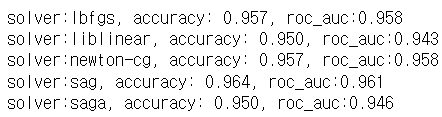  
(성능 평가 결과값은 사진 속 값과 다르게 나올 수 있습니다.)

In [33]:
solver_list = ['lbfgs','liblinear','newton-cg', 'sag', 'saga']

# solver_list에 담겨있는 각각의 solver 값을 한 번씩 적용하여 LogisticRegression을 학습하고 성능을 평가해주세요. (힌트: for 구문 활용)
# 출력 결과에서 5가지 solver 값에 대한 성능 평과 결과를 각각 얻을 수 있도록 for 구문을 활용하여 코드를 완성해주세요.
# LogisticRegression 객체의 파라미터는 solver, max_iter, random_state만 설정해주세요. max_iter는 300으로 설정하고 random_state는 11로 설정해주세요.

#for구문 작성
for solver in solver_list:
    # 로지스틱 회귀 객체를 생성해주세요.
    lg = LogisticRegression(solver=solver, max_iter=300, random_state=11)
    # fit을 사용하여 학습해주세요.
    lg.fit(Xtrain, ytrain)
    # 예측
    pred = lg.predict(Xtest)
    # accuracy와 roc_auc 측정
    accuracy = round(accuracy_score(ytest, pred),3)
    pred_proba = lg.predict_proba(Xtest)[:,1]
    roc_auc = round(roc_auc_score(ytest, pred_proba),3)
    
    print('solver :', solver, ', accuracy :', accuracy, ', roc_auc :', roc_auc)

solver : lbfgs , accuracy : 0.964 , roc_auc : 0.994
solver : liblinear , accuracy : 0.964 , roc_auc : 0.994
solver : newton-cg , accuracy : 0.964 , roc_auc : 0.994
solver : sag , accuracy : 0.964 , roc_auc : 0.994
solver : saga , accuracy : 0.964 , roc_auc : 0.994


--------

---

# 1. 결정 트리 특징

### 1-0. 앙상블은 배깅과 부스팅 방식으로 나뉩니다. 부스팅 방식의 알고리즘 중 두개를 말해보세요. (5점)

XG Boosting, Gradient Boosting

### 1-1. 아래 사진 속 결정 트리의 리프 노드는 몇개인가요?  (5점)

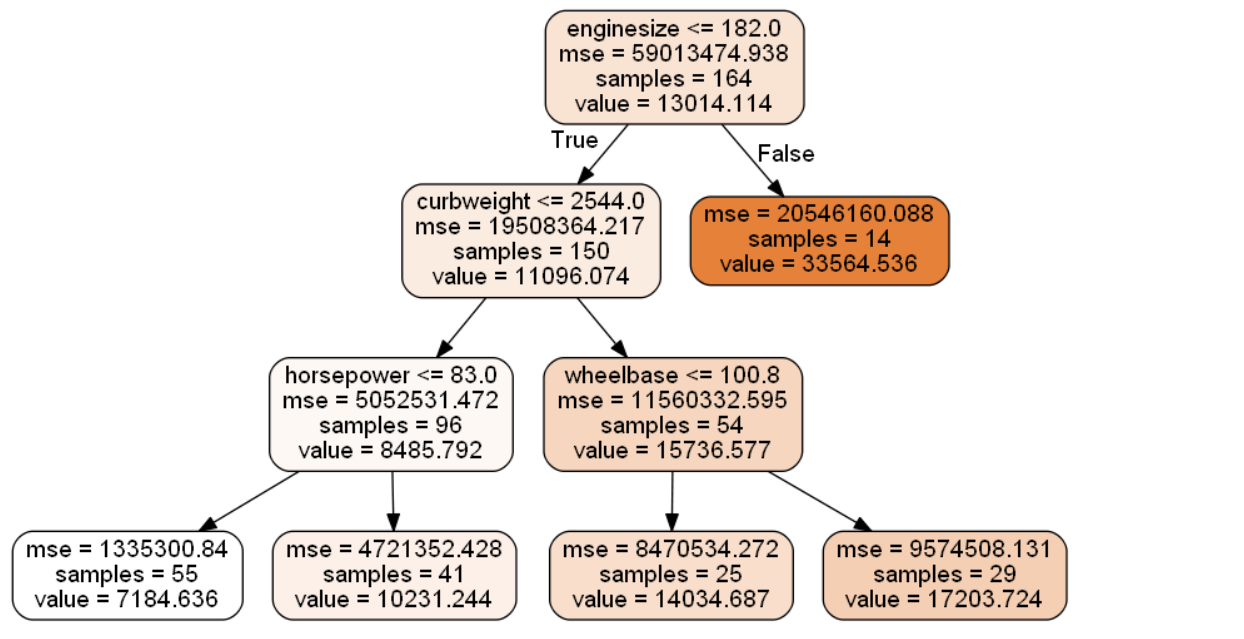

In [ ]:
from IPython.display import Image
Image("리프노드 개수.png")

5개

### 1-2. 결정 트리 모델의 정확도가 떨어질 수 있는 가장 대표적 요인은 무엇인가요?  (10점)

지나치게 많은 분할로 인해 새로운 데이터에 대해 과적합이 될 수 있다. 

---

# 2. 결정 트리 파라미터

### 2-0. 아래의 answer 리스트를 실행시켜주세요. 2번 문제의 답안이 담길 리스트입니다. 순서가 중요하니 꼭!! 순서를 지켜주세요 :)  

In [34]:
answer = []

#### 📌 보기 <br><br> a = max_samples_split <br> b = min_samples_split <br> c = max_samples_leaf <br> d = min_samples_leaf <br> e = max_features <br> f = min_features <br> g = max_depth <br> h = min_depth <br> i = max_leaf_nodes <br> j = min_leaf_nodes

#### 다음 문제들의 답을 리스트에 넣을 때 **answer.append()** 를 사용해주세요. 그렇게 해야 순서가 달라지지 않습니다.<br> (예 : answer.append('a')) <br><br>

### 2-1. 다음에 해당하는 파라미터의 변수를 answer리스트에 넣어주세요.  (4점)
<br><br> ☞ 트리의 최대 깊이를 규정합니다. 
<br> ☞ 디폴트는 None. None으로 설정하면 완벽하게 클래스 결정 값이 될 때까지 깊이를 계속 키우며 분할하기도 한다.

In [35]:
# 2-1. 답
answer.append('g')

### 2-2. 다음에 해당하는 파라미터의 변수를 answer리스트에 넣어주세요. (4점)
<br><br> ☞ 분할이 될 경우 왼쪽과 오른쪽의 브랜치 노드에서 가져야 할 최소한의 샘플 데이터 수를 뜻한다. 
<br> ☞ 큰 값으로 설정될수록, 분할될 경우 왼쪽과 오른쪽의 브랜치 노드에서 가져야 할 최소한의 샘플 데이터 수 조건을 만족시키기가 어려우므로 노드 분할을 상대적으로 덜 수행한다.

In [36]:
# 2-2. 답
answer.append('d')

### 2-3. 다음에 해당하는 파라미터의 변수를 answer리스트에 넣어주세요.  (4점)
<br><br> ☞ 노드르르 분할하기 위한 최소한의 샘플 데이터 수로 과적합을 제어하는 데 사용된다. 
<br> ☞ 디폴트는 2이고 작게 설정할수록 분할되는 노드가 많아져서 과적합 가능성이 증가한다.

In [37]:
# 2-3. 답
answer.append('b')

### 2-4. 다음에 해당하는 파라미터의 변수를 answer리스트에 넣어주세요.  (4점)
<br><br> ☞ 말단 노드(Leaf)의 최대 개수를 뜻한다. 

In [38]:
# 2-4. 답
answer.append('i')

### 2-5. 다음에 해당하는 파라미터의 변수를 answer리스트에 넣어주세요.  (4점)
<br><br> ☞ 최적의 분할을 위해 고려할 최대 피처 개수이다. 디폴트는 None으로 데이터 세트의 모든 피처를 사용해 분할 수행한다. 
<br> ☞ int형으로 지정하면 대상 피처의 개수, float형으로 지정하면 전체 피처 중 대상 피처의 퍼센트이다.

In [39]:
# 2-5. 답
answer.append('e')

### 2번 문제가 모두 끝났습니다. len(answer)을 실행하여 answer의 길이가 5인지 다시 한번 확인해주세요.

In [40]:
print(len(answer))

5


---

# 3. 결정 트리 모델의 시각화

## 당신은 결정 트리 모델의 시각화를 하려는데 한글 깨짐 현상이 발생했습니다. 위와 같은 문제를 해결하고, 결정 트리 모델을 한글로 시각화 해봅시다.

In [41]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.font_manager as fm

%matplotlib inline

# sklearn에 저장된 데이터를 불러 옵니다.
X, Y = load_iris(return_X_y = True)

# DataFrame으로 변환
df = pd.DataFrame(X, columns=['꽃받침 길이','꽃받침 넓이', '꽃잎 길이', '꽃잎 넓이'])
df['클래스'] = Y

X = df.drop(columns=['클래스'])
Y = df['클래스']

## 3-1 우선 결정트리 모델 시각화를 하기 위한 작업을 해봅시다. 필요한 라이브러리를 호출하고, 저장된 데이터를 불러왔습니다. train_test_split를 활용하여 학습용, 평가용 데이터로 분리해 봅시다. (random_state = 42, test_size = 0.2)  (5점)

In [42]:
# 3-1 답
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

## 3.2 DTmodel에 의사결정나무 모델을 초기화 하고 학습합니다.  (5점)

In [43]:
#3-2 답
DTmodel = DecisionTreeClassifier(random_state=42)
DTmodel.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

## 3.3 이제 시각화를 해볼겁니다. 아래 코드를 실행하고, C:\Windows\Fonts 경로에서 한글 폰트를 찾아 적용해봅시다.  (10점)

#### Mac OS인 분들은 한글을 포함하여 시각화 성공해주시면 정답입니다!

In [44]:
import matplotlib.font_manager as fm
#아래 코드는 C:\Windows\Fonts에 내장되어 있는 폰트를 리스트로 반환해주는 코드입니다.
font_list = [font.name for font in fm.fontManager.ttflist]
font_list

['DejaVu Serif',
 'cmss10',
 'DejaVu Sans',
 'DejaVu Serif Display',
 'DejaVu Sans',
 'DejaVu Serif',
 'cmb10',
 'cmtt10',
 'STIXSizeFourSym',
 'STIXNonUnicode',
 'cmex10',
 'STIXNonUnicode',
 'DejaVu Serif',
 'STIXGeneral',
 'cmsy10',
 'DejaVu Sans Mono',
 'DejaVu Sans',
 'STIXNonUnicode',
 'STIXGeneral',
 'STIXSizeFourSym',
 'STIXGeneral',
 'STIXNonUnicode',
 'STIXSizeThreeSym',
 'DejaVu Sans Mono',
 'cmr10',
 'STIXSizeFiveSym',
 'STIXSizeTwoSym',
 'DejaVu Serif',
 'STIXSizeOneSym',
 'DejaVu Sans Display',
 'STIXSizeThreeSym',
 'DejaVu Sans Mono',
 'cmmi10',
 'DejaVu Sans Mono',
 'STIXGeneral',
 'STIXSizeTwoSym',
 'STIXSizeOneSym',
 'DejaVu Sans',
 'D2Coding',
 'HCR Dotum',
 'AIGDT',
 'Constantia',
 'Bodoni MT',
 'Lucida Sans Typewriter',
 'Symbol',
 'Castellar',
 'Proxy 9',
 'Franklin Gothic Medium',
 'Showcard Gothic',
 'Cafe24 Shiningstar',
 'Cambria',
 'Bauhaus 93',
 'Proxy 5',
 'ItalicC',
 'Franklin Gothic Book',
 'ZWAdobeF',
 'Times New Roman',
 'Yu Gothic',
 'Ebrima',
 'Arial'

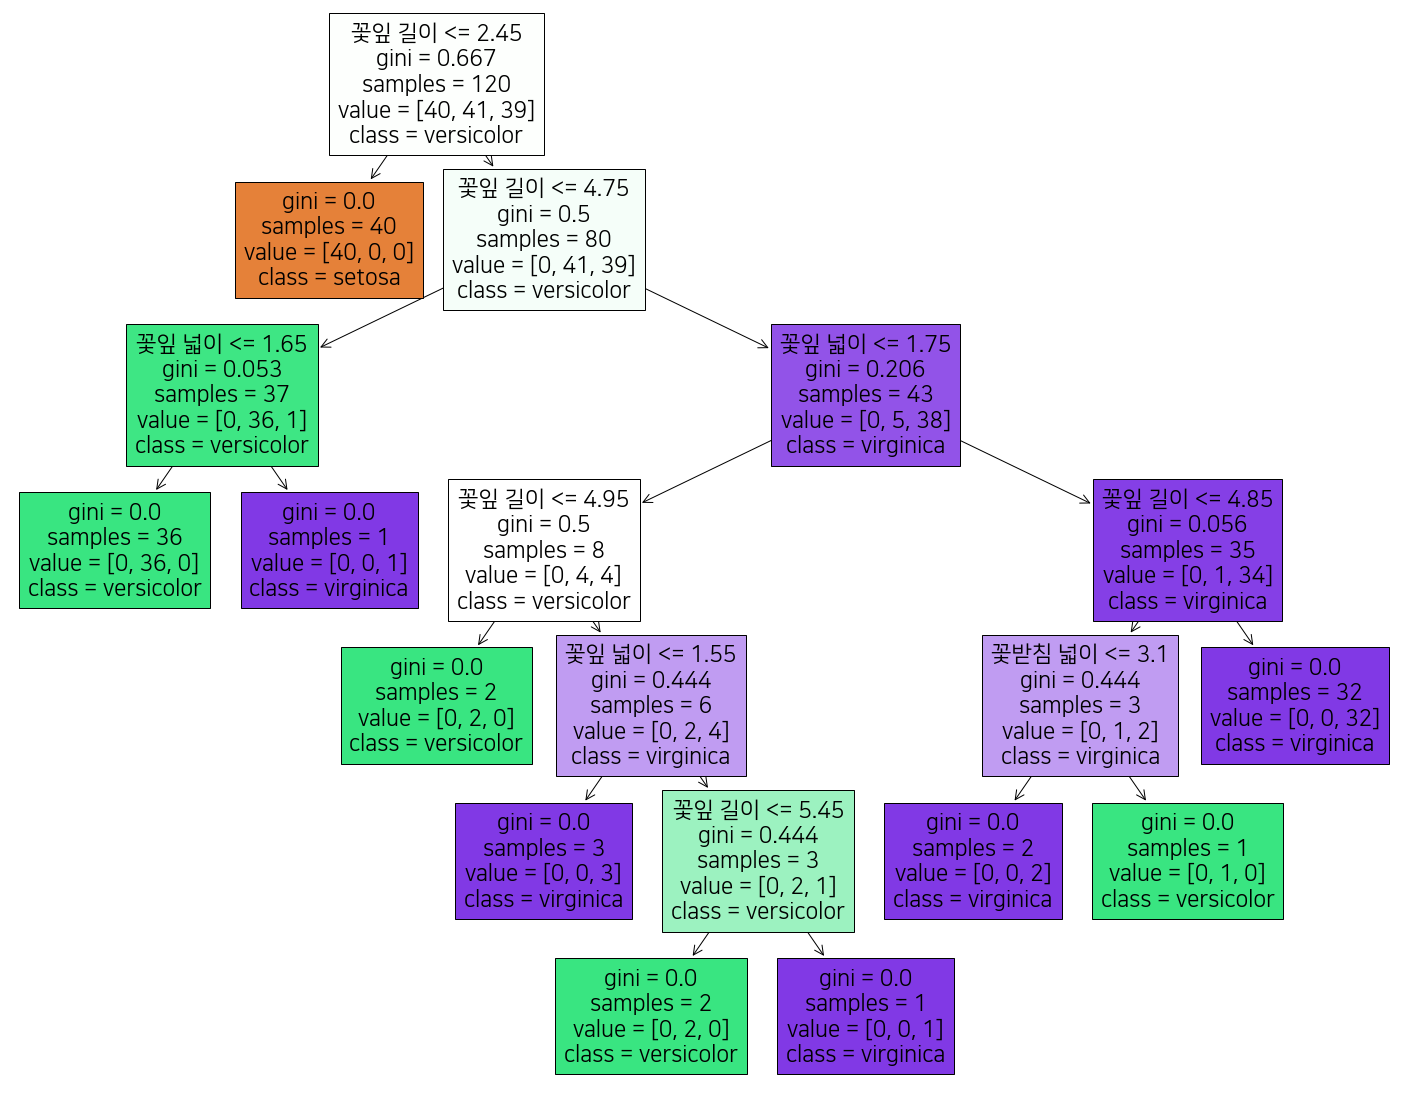

In [45]:
# 3-3 답 None 값을 채워주세요.
# !!Hint!! 1번째 None 값에 폰트 이름이 들어갑니다. 

plt.rc('font', family='NanumSquare')
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(DTmodel, 
                   feature_names=['꽃받침 길이','꽃받침 넓이', '꽃잎 길이', '꽃잎 넓이'],  
                   class_names=['setosa', 'versicolor', 'virginica'],
                   filled=True)


# 4. 결정트리 과적합(20점)

### 4-1. make_classification() 함수를 사용해 2개의 피처가 4가지 유형의 클래스 값을 가지는 데이터 세트를 만드시오. (3점) 

In [46]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# 2차원 시각화를 위해서 feature는 2개, 결정값 클래스는 4가지 유형의 classification 샘플 데이터 생성. 
X_features, y_labels = make_classification(n_features = 2, n_redundant = 0, n_informative = 2,
                                          n_classes = 4, n_clusters_per_class = 1, random_state = 0)

### 4-2. plot 형태로 2개의 feature로 2차원 좌표 시각화하고 각 클래스값은 다른 색깔로 표시하여 출력하시오. (4점)


C:\Users\happy\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\happy\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


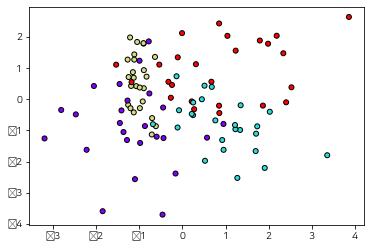

In [47]:
# 그래프 시각화
plt.scatter(X_features[:, 0], X_features[:, 1], marker='o', c=y_labels, s=25, cmap='rainbow', edgecolor='k')

### 4-3. 아래의 셀을 실행시키고 visualize_boundary() 함수의 역할 및 기능을 설명하시오. (3점)

In [48]:

import numpy as np

# Classifier의 Decision Boundary를 시각화 하는 함수
def visualize_boundary(model, X, y):
    fig,ax = plt.subplots()
    
    # 학습 데이타 scatter plot으로 나타내기
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
    
    # 호출 파라미터로 들어온 training 데이타로 model 학습 . 
    model.fit(X, y)
    # meshgrid 형태인 모든 좌표값으로 예측 수행. 
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # contourf() 를 이용하여 class boundary 를 visualization 수행. 
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow', clim=(y.min(), y.max()),
                           zorder=1)

답 : 결정트리가 주어진 데이터를 4개의 클래스로 어떻게 나누는지 먼저 산점도로 나타낸 다음 그 경계를 색이 있는 박스로 시각화하는 함수이다. 

### 4-4. 특정한 트리 생성 제약이 없는 결정트리의 학습을 시키고 위의 visalize_boundary()함수를 사용하여 결정경계를 시각화 하시오. (3점)

C:\Users\happy\AppData\Local\Temp/ipykernel_28936/1108106523.py:23: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


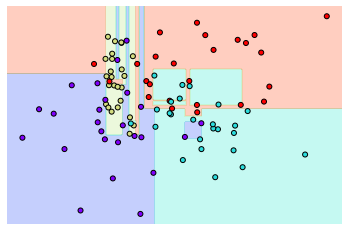

In [49]:
from sklearn.tree import DecisionTreeClassifier

# 특정한 트리 생성 제약없는 결정 트리의 Decsion Boundary 시각화.
dt_clf = DecisionTreeClassifier().fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

### 4-5. 7개 이하이 데이터는 리프노드를 생성할 수 있도록 규칙을 변경하고 하이퍼 파라미터를 변경해 결정기준 경계가 어떻게 변하는지 살펴보시오. (3점)

C:\Users\happy\AppData\Local\Temp/ipykernel_28936/1108106523.py:23: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


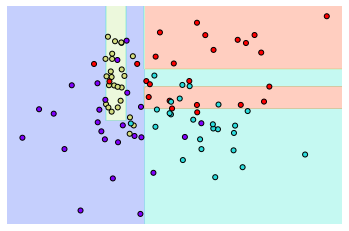

In [50]:
# min_samples_leaf=6 으로 트리 생성 조건을 제약한 Decision Boundary 시각화

dt_clf = DecisionTreeClassifier(min_samples_leaf=6).fit(X_features, y_labels)
visualize_boundary(dt_clf, X_features, y_labels)

### 4-6. 4-4의 출력결과와 4-5의 출력결과를 과적합 측면에서 비교하여 서술하시오(4점)

답 : 생성조건을 제약하기 전, 4-4의 출력 결과를 보면 4-5에 비해 분할이 지나치게 자주 일어나서 결정기준 경계가 많아짐을 확인할 수 있다. 이는 과적합을 의미하며 이후 테스트 데이터에 대하여 예측 정확도를 떨어뜨린다. 

# 5. 결정 트리 실습

#### 5-1. penguins 데이터셋을 불러오고 간단한 데이터 전처리를 해주겠습니다. 아래 코드를 실행해주세요! (3점)

In [51]:
import seaborn as sns
import numpy as np
import pandas as pd 

penguins= sns.load_dataset("penguins")

# 이상치 처리
penguins["sex"] = penguins["sex"].replace(".",np.NaN)

# 결측치 처리
cols=["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"] # 숫자 데이터 컬럼

#1. 숫자데이터로 이루어진 컬럼 결측치 -> 평균값으로 채우기
for i in range(len(cols)):
    penguins[cols[i]] = penguins[cols[i]].fillna(penguins[cols[i]].mean()) # 평균값으로 결측치를 채운다.

#2. 문자 데이터로 이루어진 컬럼 결측치 -> row 제거
penguins=penguins.dropna(subset=["sex"])


penguins.isna().sum(axis=0)

species              0
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

In [52]:
#피처와 레이블 분리

X = penguins.drop(["species"],axis=1)
y = penguins["species"]

#### 5-2. train_test_split을 사용하여 학습셋과 테스트셋을 분리해주세요.(test 데이터의 비율이 20%가 되게 분리 해주세요) (3점)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [54]:
X_train

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
19,Torgersen,46.0,21.5,194.0,4200.0,Male
234,Biscoe,45.8,14.6,210.0,4200.0,Female
71,Torgersen,39.7,18.4,190.0,3900.0,Male
279,Biscoe,50.4,15.3,224.0,5550.0,Male
276,Biscoe,43.8,13.9,208.0,4300.0,Female
...,...,...,...,...,...,...
299,Biscoe,45.2,16.4,223.0,5950.0,Male
201,Dream,49.8,17.3,198.0,3675.0,Female
156,Dream,52.7,19.8,197.0,3725.0,Male
122,Torgersen,40.2,17.0,176.0,3450.0,Female


#### 5-3. 문자데이터로 이루어진 컬럼은 원-핫 인코딩을, 숫자데이터로 이루어진 컬럼은 스케일링을 진행하겠습니다. 아래 코드를 실행시켜주세요. (3점)

In [55]:
# 스케일링
num_cols =["bill_length_mm","bill_depth_mm","flipper_length_mm","body_mass_g"]

from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.fit_transform(X_test[num_cols])


In [56]:
# 원-핫 인코딩
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [57]:
# y_train은 문자열이기 때문에 레이블 인코딩을 진행해줍니다.
from sklearn.preprocessing import LabelEncoder

e=LabelEncoder()
y_train=e.fit_transform(y_train)
y_test=e.fit_transform(y_test)

#### 5-4. 이제 decisiontree를 활용하여 학습시켜주겠습니다. 먼저 decisiontressClassifier의 하이퍼 파라미터는 모두 디폴트 값으로 설정해 수행하고, 정확도를 확인해주세요. (random_state는 156으로 설정해주세요.) (4점)

In [58]:
dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
accuracy_score(y_test, pred)

0.9402985074626866

#### 5-5. 이번에는 결정 트리의 트리 깊이와 min_samples_leaf가 예측 정확도에 주는 영향을 살펴보겠습니다. (GridSearchCV 사용)  max_depth와 min_samples_leaf는 자유롭게 설정해주시고, scoring은 accuracy, cv는 5로 설정해주세요. 이후 GridSearchCV 최고 평균 정확도 수치와 최적 하이퍼 파라미터를 출력해주세요. (3점)

In [59]:
from sklearn.model_selection import GridSearchCV

params= {'max_depth':[2,3,4],'min_samples_split':[4,5,6]}

grid=GridSearchCV(dt_clf, param_grid=params, cv=5, scoring='accuracy', refit=True)
grid.fit(X_train,y_train)
pd.DataFrame(grid.cv_results_)

# GridSearchCV 최고 평균 정확도
print(grid.best_score_)

# GridSearchCV 최적 하이퍼 파라미터
print(grid.best_params_)

0.9699510831586304
{'max_depth': 4, 'min_samples_split': 4}


#### 5-6. 마지막으로 별도의 테스트 세트에서 결정 트리의 정확도를 측정해보겠습니다. max_depth는 3으로 고정하고,min_samples_leaf를 자유롭게 변경하며 변화에 따른 값을 측정해주세요. (4점)

In [60]:
min_samples_leaf=[2,4,6,8]

# min_samples_leaf 값을 변화시키며 그때마다 학습과 테스트 세트에서의 예측 성능 측정
for i in min_samples_leaf:
    DT_clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf= i)
    DT_clf.fit(X_train, y_train)
    prediction = DT_clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, prediction)

    print('설정한 min_samples_leaf 값 : ', i, '설정값에 따른 결정 트리의 정확도 : ', accuracy)

설정한 min_samples_leaf 값 :  2 설정값에 따른 결정 트리의 정확도 :  0.9701492537313433
설정한 min_samples_leaf 값 :  4 설정값에 따른 결정 트리의 정확도 :  0.9701492537313433
설정한 min_samples_leaf 값 :  6 설정값에 따른 결정 트리의 정확도 :  0.9701492537313433
설정한 min_samples_leaf 값 :  8 설정값에 따른 결정 트리의 정확도 :  0.9701492537313433
